<a href="https://colab.research.google.com/github/HarisankarRNR/Dual_Track_Model-Image_Classification/blob/main/Swin_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install torchinfo
!pip install timm # kaggle doesnt have it installed by default
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import numpy as np
import pandas as pd
import os

import PIL
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torchvision
import torch.optim as optim
import timm
from  torchvision.ops.deform_conv import DeformConv2d
import torchinfo
import sys
from tqdm import tqdm
import time
import copy
import os
import warnings

In [ ]:
# import torch
# import torchvision
# from torchvision import transforms
# from torch.utils.data import DataLoader, ConcatDataset, Subset
# import numpy as np
# from torch.utils.data import Dataset, DataLoader

# warnings.filterwarnings('ignore')

# device = "cuda" if torch.cuda.is_available() else "cpu"
# kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}

# train_dataset_path = '/content/drive/MyDrive/CCPS_research/LIMUC_dataset/aug2/'

# train_transform = transforms.Compose([
#                                     transforms.Resize((224,224)),
#                                     transforms.ToTensor()
#                                     ])


# class TrainDataset(Dataset):
#     def __init__(self, root, transform=None):
#         self.train = torchvision.datasets.ImageFolder(root=root, transform=transform)

#     def __len__(self):
#         return len(self.train)

#     def __getitem__(self, idx):
#         image, label = self.train[idx]
#         label = torch.tensor(label, dtype=torch.int64)  # Convert label to tensor
#         return image, label
#     def targets(self):
#       return self.train.targets

# def train_dataloader_func():

#     # Define your original dataset (e.g., CIFAR-10)
#     train_dataset = TrainDataset(train_dataset_path, transform=train_transform)
#     print("original dataset len: ",len(train_dataset))

#     # Define data augmentation transformations
#     augmentation_transforms = transforms.Compose([
#                                     transforms.Resize((224,224)),
#                                     transforms.RandomRotation(30),
#                                     transforms.RandomVerticalFlip(),
#                                     transforms.RandomHorizontalFlip(),
#                                     # transforms.ToTensor()
#                                     ])

#     # Define the number of augmented samples you want per class
#     desired_samples_per_class = 5000

#     # Create empty lists to store augmented datasets
#     augmented_datasets = []

#     # Loop through each class
#     for class_label in range(1):
#         # Create a subset of the original dataset for the current class
#         class_indices = np.where(np.array(train_dataset.targets()) == class_label)[0]
#         class_subset = Subset(train_dataset, class_indices)
#         if len(class_subset)<5000:
#             print(f"Images in label {class_label} before aug: {len(class_subset)}")
#             # Calculate the number of augmentations needed for this class
#             num_augmentations = desired_samples_per_class - len(class_subset)

#             # Augment the data and concatenate
#             augmented_samples = []
#             while(len(augmented_samples)<num_augmentations):
#                 for i, (image, label) in enumerate(class_subset):
#                     augmented_image = augmentation_transforms(image)
#                     augmented_samples.append((augmented_image,label))

#             # Create a new dataset with the augmented samples
#             augmented_images, augmented_labels = zip(*augmented_samples)
#             augmented_images = torch.stack(augmented_images)
#             augmented_labels = torch.tensor([int(label) for label in augmented_labels])
#             # print(type(augmented_labels[0]))
#             augmented_dataset = torch.utils.data.TensorDataset(augmented_images, augmented_labels)
#             # augmented_datasets.append(augmented_dataset)
#             print(f"Images in label {class_label} after aug: {len(augmented_dataset)}")
#             augmented_datasets.append(augmented_dataset)

#     # Concatenate all augmented datasets
#     final_dataset = ConcatDataset([train_dataset] + augmented_datasets)
#     folder_path = '/content/drive/MyDrive/CCPS_research/LIMUC_dataset/Augmented_images'
#     if not os.path.exists(folder_path):
#       os.mkdir(folder_path)
#     classes = train_dataset.train.classes
#     count=0
#     for img,label in final_dataset:
#         sub_folder = os.path.join(folder_path,classes[label])
#         if not os.path.exists(sub_folder):
#           os.mkdir(sub_folder)
#         image = f"{count}.jpg"
#         torchvision.utils.save_image(tensor = img,fp=os.path.join(sub_folder,image))
#         count+=1
#         if count%500==0:
#           print(count)

#     # print("final dataset len: ",len(final_dataset))
#     # batch_size = 32
#     # dataloader = DataLoader(final_dataset, batch_size=batch_size, shuffle=True)
#     # # Create a data loader for the final dataset
#     # return dataloader,len(final_dataset)

# train_dataloader_func()

# # Now, you can use the 'dataloader' to train your model with the augmented data.

In [ ]:
# import torch
# import torchvision
# from torchvision import transforms
# from torch.utils.data import DataLoader, ConcatDataset, Subset
# import numpy as np
# from torch.utils.data import Dataset, DataLoader

# warnings.filterwarnings('ignore')

# device = "cuda" if torch.cuda.is_available() else "cpu"
# kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}

# valid_dataset_path = '/content/drive/MyDrive/CCPS_research/original_dataset/valid_inpainted'

# train_transform = transforms.Compose([
#                                     transforms.Resize((224,224)),
#                                     transforms.RandomRotation(45),
#                                     transforms.RandomVerticalFlip(),
#                                     transforms.RandomHorizontalFlip(),
#                                     transforms.RandomAffine(degrees = 0, translate = (0.2, 0)),
#                                     transforms.RandomAffine(degrees = 0, translate = (0, 0.2)),
#                                     transforms.ToTensor()
#                                     ])


# class ValidDataset(Dataset):
#     def __init__(self, root, transform=None):
#         self.train = torchvision.datasets.ImageFolder(root=root, transform=transform)

#     def __len__(self):
#         return len(self.train)

#     def __getitem__(self, idx):
#         image, label = self.train[idx]
#         label = torch.tensor(label, dtype=torch.int64)  # Convert label to tensor
#         return image, label
#     def targets(self):
#       return self.train.targets

# def valid_dataloader_func():

#     # Define your original dataset (e.g., CIFAR-10)
#     valid_dataset = ValidDataset(valid_dataset_path, transform=train_transform)
#     print("original dataset len: ",len(valid_dataset))

#     # Define data augmentation transformations
#     augmentation_transforms = transforms.Compose([
#                                     transforms.Resize((224,224)),
#                                     transforms.RandomRotation(45),
#                                     transforms.RandomVerticalFlip(),
#                                     transforms.RandomHorizontalFlip(),
#                                     transforms.RandomAffine(degrees = 0, translate = (0.2, 0)),
#                                     transforms.RandomAffine(degrees = 0, translate = (0, 0.2)),
#                                     # transforms.ToTensor()
#                                     ])

#     # Define the number of augmented samples you want per class
#     desired_samples_per_class = 200

#     # Create empty lists to store augmented datasets
#     augmented_datasets = []

#     # Loop through each class
#     for class_label in range(23):
#         # Create a subset of the original dataset for the current class
#         class_indices = np.where(np.array(valid_dataset.targets()) == class_label)[0]
#         class_subset = Subset(valid_dataset, class_indices)
#         if len(class_subset)<100:
#             print(f"Images in label {class_label} before aug: {len(class_subset)}")
#             # Calculate the number of augmentations needed for this class
#             num_augmentations = desired_samples_per_class - len(class_subset)

#             # Augment the data and concatenate
#             augmented_samples = []
#             while(len(augmented_samples)<num_augmentations):
#                 for i, (image, label) in enumerate(class_subset):
#                     augmented_image = augmentation_transforms(image)
#                     augmented_samples.append((augmented_image,label))

#             # Create a new dataset with the augmented samples
#             augmented_images, augmented_labels = zip(*augmented_samples)
#             augmented_images = torch.stack(augmented_images)
#             augmented_labels = torch.tensor([int(label) for label in augmented_labels])
#             # print(type(augmented_labels[0]))
#             augmented_dataset = torch.utils.data.TensorDataset(augmented_images, augmented_labels)
#             # augmented_datasets.append(augmented_dataset)
#             print(f"Images in label {class_label} after aug: {len(augmented_dataset)}")
#             augmented_datasets.append(augmented_dataset)

#     # Concatenate all augmented datasets
#     final_dataset = ConcatDataset([valid_dataset] + augmented_datasets)
#     print("final dataset len: ",len(final_dataset))

#     # Create a data loader for the final dataset

#     batch_size = 32
#     valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
#     return valid_dataloader,len(valid_dataset)

# valid_dataloader,len_valid_dataset = valid_dataloader_func()
# # Now, you can use the 'dataloader' to train your model with the augmented data.

In [ ]:
transform = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.RandomRotation(45),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                ])
test_transform = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                    ])

device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}

train_dataset_path = '/content/drive/MyDrive/CCPS_research/PlantVillage/grape_leaves_split_aug/train'
valid_dataset_path = '/content/drive/MyDrive/CCPS_research/PlantVillage/grape_leaves_split_aug/val'
test_dataset_path = '/content/drive/MyDrive/CCPS_research/PlantVillage/grape_leaves_split_aug/test'

train_dataset = datasets.ImageFolder(train_dataset_path, transform=transform)
valid_dataset = datasets.ImageFolder(valid_dataset_path, transform=transform)
test_dataset = datasets.ImageFolder(test_dataset_path,transform=test_transform)

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, **kwargs)
valid_dataloader =  torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True, **kwargs)
test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, **kwargs)

CLASSES = train_dataset.classes
train_len = len(train_dataset)
valid_len = len(valid_dataset)
test_len = len(test_dataset)

In [ ]:
dataloaders = {
    "train": train_dataloader,
    "val": valid_dataloader
}
dataset_sizes = {
    "train": train_len,
    "val": valid_len
}

In [ ]:
import torch
from torch import nn, einsum
import numpy as np
from einops import rearrange, repeat


class CyclicShift(nn.Module):
    def __init__(self, displacement):
        super().__init__()
        self.displacement = displacement

    def forward(self, x):
        return torch.roll(x, shifts=(self.displacement, self.displacement), dims=(1, 2))


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)


def create_mask(window_size, displacement, upper_lower, left_right):
    mask = torch.zeros(window_size ** 2, window_size ** 2)

    if upper_lower:
        mask[-displacement * window_size:, :-displacement * window_size] = float('-inf')
        mask[:-displacement * window_size, -displacement * window_size:] = float('-inf')

    if left_right:
        mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2', h1=window_size, h2=window_size)
        mask[:, -displacement:, :, :-displacement] = float('-inf')
        mask[:, :-displacement, :, -displacement:] = float('-inf')
        mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

    return mask


def get_relative_distances(window_size):
    indices = torch.tensor(np.array([[x, y] for x in range(window_size) for y in range(window_size)]))
    distances = indices[None, :, :] - indices[:, None, :]
    return distances


class WindowAttention(nn.Module):
    def __init__(self, dim, heads, head_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        inner_dim = head_dim * heads

        self.heads = heads
        self.scale = head_dim ** -0.5
        self.window_size = window_size
        self.relative_pos_embedding = relative_pos_embedding
        self.shifted = shifted

        if self.shifted:
            displacement = window_size // 2
            self.cyclic_shift = CyclicShift(-displacement)
            self.cyclic_back_shift = CyclicShift(displacement)
            self.upper_lower_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                             upper_lower=True, left_right=False), requires_grad=False)
            self.left_right_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                            upper_lower=False, left_right=True), requires_grad=False)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        if self.relative_pos_embedding:
            self.relative_indices = get_relative_distances(window_size) + window_size - 1
            self.pos_embedding = nn.Parameter(torch.randn(2 * window_size - 1, 2 * window_size - 1))
        else:
            self.pos_embedding = nn.Parameter(torch.randn(window_size ** 2, window_size ** 2))

        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        if self.shifted:
            x = self.cyclic_shift(x)

        b, n_h, n_w, _, h = *x.shape, self.heads

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        nw_h = n_h // self.window_size
        nw_w = n_w // self.window_size

        q, k, v = map(
            lambda t: rearrange(t, 'b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d',
                                h=h, w_h=self.window_size, w_w=self.window_size), qkv)

        dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale

        if self.relative_pos_embedding:
            dots += self.pos_embedding[self.relative_indices[:, :, 0], self.relative_indices[:, :, 1]]
        else:
            dots += self.pos_embedding

        if self.shifted:
            dots[:, :, -nw_w:] += self.upper_lower_mask
            dots[:, :, nw_w - 1::nw_w] += self.left_right_mask

        attn = dots.softmax(dim=-1)

        out = einsum('b h w i j, b h w j d -> b h w i d', attn, v)
        out = rearrange(out, 'b h (nw_h nw_w) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)',
                        h=h, w_h=self.window_size, w_w=self.window_size, nw_h=nw_h, nw_w=nw_w)
        out = self.to_out(out)

        if self.shifted:
            out = self.cyclic_back_shift(out)
        return out


class SwinBlock(nn.Module):
    def __init__(self, dim, heads, head_dim, mlp_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        self.attention_block = Residual(PreNorm(dim, WindowAttention(dim=dim,
                                                                     heads=heads,
                                                                     head_dim=head_dim,
                                                                     shifted=shifted,
                                                                     window_size=window_size,
                                                                     relative_pos_embedding=relative_pos_embedding)))
        self.mlp_block = Residual(PreNorm(dim, FeedForward(dim=dim, hidden_dim=mlp_dim)))

    def forward(self, x):
        x = self.attention_block(x)
        x = self.mlp_block(x)
        return x


class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, downscaling_factor):
        super().__init__()
        self.downscaling_factor = downscaling_factor
        self.patch_merge = nn.Unfold(kernel_size=downscaling_factor, stride=downscaling_factor, padding=0)
        self.linear = nn.Linear(in_channels * downscaling_factor ** 2, out_channels)

    def forward(self, x):
        b, c, h, w = x.shape
        new_h, new_w = h // self.downscaling_factor, w // self.downscaling_factor
        x = self.patch_merge(x).view(b, -1, new_h, new_w).permute(0, 2, 3, 1)
        x = self.linear(x)
        return x


class StageModule(nn.Module):
    def __init__(self, in_channels, hidden_dimension, layers, downscaling_factor, num_heads, head_dim, window_size,
                 relative_pos_embedding):
        super().__init__()
        assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block.'

        self.patch_partition = PatchMerging(in_channels=in_channels, out_channels=hidden_dimension,
                                            downscaling_factor=downscaling_factor)

        self.layers = nn.ModuleList([])
        for _ in range(layers // 2):
            self.layers.append(nn.ModuleList([
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=False, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=True, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
            ]))

    def forward(self, x):
        x = self.patch_partition(x)
        for regular_block, shifted_block in self.layers:
            x = regular_block(x)
            x = shifted_block(x)
        return x.permute(0, 3, 1, 2)


class SwinTransformer(nn.Module):
    def __init__(self, *, hidden_dim, layers, heads, channels=3, num_classes=1000, head_dim=32, window_size=7,
                 downscaling_factors=(4, 2, 2, 2), relative_pos_embedding=True):
        super().__init__()

        self.stage1 = StageModule(in_channels=channels, hidden_dimension=hidden_dim, layers=layers[0],
                                  downscaling_factor=downscaling_factors[0], num_heads=heads[0], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage2 = StageModule(in_channels=hidden_dim, hidden_dimension=hidden_dim * 2, layers=layers[1],
                                  downscaling_factor=downscaling_factors[1], num_heads=heads[1], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage3 = StageModule(in_channels=hidden_dim * 2, hidden_dimension=hidden_dim * 4, layers=layers[2],
                                  downscaling_factor=downscaling_factors[2], num_heads=heads[2], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage4 = StageModule(in_channels=hidden_dim * 4, hidden_dimension=hidden_dim * 8, layers=layers[3],
                                  downscaling_factor=downscaling_factors[3], num_heads=heads[3], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)

        # self.mlp_head = nn.Sequential(
        #     nn.LayerNorm(hidden_dim * 8),
        #     nn.Linear(hidden_dim * 8, num_classes)
        # )

    def forward(self, img):
        x = self.stage1(img)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        # x = x.mean(dim=[2, 3])
        return x


def swin_t(hidden_dim=96, layers=(2, 2, 6, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


def swin_s(hidden_dim=96, layers=(2, 2, 18, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


def swin_b(hidden_dim=128, layers=(2, 2, 18, 2), heads=(4, 8, 16, 32), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


def swin_l(hidden_dim=192, layers=(2, 2, 18, 2), heads=(6, 12, 24, 48), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=3, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input,dim=1)
        # print("logpt is:",logpt)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)
        loss = -1 * (1-pt)**self.gamma * logpt
        # print("loss is :",loss)
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
class swin_model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6,kernel_size = 2,stride=2)
    self.swin_out = SwinTransformer(hidden_dim = 12,
                      layers = (2,2,6,2),
                      heads = (3,6,12,24),
                      channels = 6,
                      num_classes = 23,
                      downscaling_factors=(2, 2, 2, 2)
                      )
  def forward(self,x):
    x = self.conv1(x)
    x = self.swin_out(x)
    return x

In [ ]:
class LinearLayer(nn.Module):
  def __init__(self,input):
    super().__init__()
    self.flat = nn.Flatten()
    self.linear1 = nn.Linear(input, 512)
    self.act1 = nn.ReLU()
    self.drop = nn.Dropout(0.3)
    self.linear2 = nn.Linear(512, 4)

  def forward(self,x):
    x = self.flat(x)
    x = self.act1(self.linear1(x))
    x = self.drop(x)
    x = self.linear2(x)
    return x

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.swin_out = swin_model()
    self.linear = LinearLayer(4704)

  def forward(self,x):
    x = self.swin_out(x)
    x = self.linear(x)
    return x

In [ ]:

model = Model()
torchinfo.summary(model, (32,3, 224, 224))

Layer (type:depth-idx)                                                 Output Shape              Param #
Model                                                                  [32, 4]                   --
├─swin_model: 1-1                                                      [32, 96, 7, 7]            --
│    └─Conv2d: 2-1                                                     [32, 6, 112, 112]         78
│    └─SwinTransformer: 2-2                                            [32, 96, 7, 7]            --
│    │    └─StageModule: 3-1                                           [32, 12, 56, 56]          17,200
│    │    └─StageModule: 3-2                                           [32, 24, 28, 28]          52,876
│    │    └─StageModule: 3-3                                           [32, 48, 14, 14]          575,916
│    │    └─StageModule: 3-4                                           [32, 96, 7, 7]            762,868
├─LinearLayer: 1-2                                                     [32, 4

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)
# criterion = FocalLoss(alpha =class_weights,gamma=2)
criterion = criterion.to(device)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.97)
os.chdir("/content/drive/MyDrive/CCPS_research/logs_grapes")

In [ ]:
# checkpoint = torch.load(f"checkpoints_swin/model15.pt")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
# print(loss)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, path, train_log, valid_log, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    df_train = pd.DataFrame(columns = ['epoch', 'train_loss', 'train_acc'])
    df_val = pd.DataFrame(columns = ['epoch','val_loss','val_acc'])
    for epoch in range(1,num_epochs+1):
        print(f'Epoch {epoch}/{num_epochs}')
        print("-"*10)


        if not os.path.isdir(path):
          os.mkdir(path)
        # else:
        #   checkpoint = torch.load(f"checkpoints/model{epoch-1}.pt")
        #   model.load_state_dict(checkpoint['model_state_dict'])
        #   optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
          # epoch = checkpoint['epoch']
          # loss = checkpoint['loss']

        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    # print("outputs are: ",outputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    # print("\nEntering loss")
                    loss = criterion(outputs, labels)
                    # print("loss obtained: ",loss)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step() # step at end of epoch

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            # print(type(epoch))
            # print(type(epoch_loss))
            # print(type(epoch_acc))
            if phase=='train':
              # print("Done")
              df_new_row = pd.DataFrame({ 'epoch': [epoch], 'train_loss': [epoch_loss],'train_acc':[epoch_acc.cpu()] })
              # print("done2")
              df_train = pd.concat([df_train, df_new_row])
              df_train.to_csv(f'{path}/{train_log}.csv')
            elif phase=='val':
              df_new_row = pd.DataFrame({ 'epoch': [epoch], 'val_loss': [epoch_loss],'val_acc':[epoch_acc.cpu()] })
              df_val = pd.concat([df_val, df_new_row])
              df_val.to_csv(f'{path}/{valid_log}.csv')
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            ## save torch model for checkpoints
            if epoch%5==0:
              torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': epoch_loss,
              }, f"{path}/model{epoch}.pt")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()

    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, "swin_grapes","train_cnn","val_cnn",num_epochs=100)

Epoch 1/100
----------


100%|██████████| 87/87 [06:25<00:00,  4.43s/it]


train Loss: 1.0706 Acc: 0.4964


100%|██████████| 29/29 [02:41<00:00,  5.56s/it]


val Loss: 0.8264 Acc: 0.6257

Epoch 2/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.63it/s]


train Loss: 0.6822 Acc: 0.7099


100%|██████████| 29/29 [00:04<00:00,  5.83it/s]


val Loss: 0.6331 Acc: 0.7109

Epoch 3/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.86it/s]


train Loss: 0.5892 Acc: 0.7484


100%|██████████| 29/29 [00:04<00:00,  6.36it/s]


val Loss: 0.7149 Acc: 0.7087

Epoch 4/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.87it/s]


train Loss: 0.5582 Acc: 0.7599


100%|██████████| 29/29 [00:06<00:00,  4.34it/s]


val Loss: 0.5373 Acc: 0.7454

Epoch 5/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.82it/s]


train Loss: 0.5083 Acc: 0.8001


100%|██████████| 29/29 [00:04<00:00,  6.23it/s]


val Loss: 0.4488 Acc: 0.7972

Epoch 6/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.86it/s]


train Loss: 0.4554 Acc: 0.8181


100%|██████████| 29/29 [00:05<00:00,  5.42it/s]


val Loss: 0.4233 Acc: 0.8285

Epoch 7/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.87it/s]


train Loss: 0.4241 Acc: 0.8278


100%|██████████| 29/29 [00:05<00:00,  5.41it/s]


val Loss: 0.4932 Acc: 0.7853

Epoch 8/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.89it/s]


train Loss: 0.4093 Acc: 0.8325


100%|██████████| 29/29 [00:04<00:00,  6.52it/s]


val Loss: 0.4172 Acc: 0.8231

Epoch 9/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.89it/s]


train Loss: 0.3777 Acc: 0.8476


100%|██████████| 29/29 [00:05<00:00,  5.07it/s]


val Loss: 0.3801 Acc: 0.8468

Epoch 10/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.74it/s]


train Loss: 0.3795 Acc: 0.8490


100%|██████████| 29/29 [00:04<00:00,  6.19it/s]


val Loss: 0.3418 Acc: 0.8695

Epoch 11/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.87it/s]


train Loss: 0.3537 Acc: 0.8580


100%|██████████| 29/29 [00:04<00:00,  6.09it/s]


val Loss: 0.3845 Acc: 0.8501

Epoch 12/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.79it/s]


train Loss: 0.3792 Acc: 0.8501


100%|██████████| 29/29 [00:06<00:00,  4.44it/s]


val Loss: 0.3827 Acc: 0.8414

Epoch 13/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.86it/s]


train Loss: 0.3180 Acc: 0.8807


100%|██████████| 29/29 [00:04<00:00,  6.27it/s]


val Loss: 0.3006 Acc: 0.8749

Epoch 14/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.85it/s]


train Loss: 0.3419 Acc: 0.8728


100%|██████████| 29/29 [00:05<00:00,  5.42it/s]


val Loss: 0.2760 Acc: 0.8867

Epoch 15/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.75it/s]


train Loss: 0.2921 Acc: 0.8832


100%|██████████| 29/29 [00:05<00:00,  5.74it/s]


val Loss: 0.3385 Acc: 0.8759

Epoch 16/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.79it/s]


train Loss: 0.2670 Acc: 0.8936


100%|██████████| 29/29 [00:04<00:00,  6.10it/s]


val Loss: 0.2775 Acc: 0.8857

Epoch 17/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.67it/s]


train Loss: 0.2764 Acc: 0.8875


100%|██████████| 29/29 [00:06<00:00,  4.37it/s]


val Loss: 0.3028 Acc: 0.8738

Epoch 18/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.70it/s]


train Loss: 0.2664 Acc: 0.8986


100%|██████████| 29/29 [00:04<00:00,  6.19it/s]


val Loss: 0.2992 Acc: 0.8867

Epoch 19/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.78it/s]


train Loss: 0.2529 Acc: 0.8958


100%|██████████| 29/29 [00:05<00:00,  5.30it/s]


val Loss: 0.2790 Acc: 0.8921

Epoch 20/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.64it/s]


train Loss: 0.2962 Acc: 0.8817


100%|██████████| 29/29 [00:04<00:00,  5.84it/s]


val Loss: 0.2952 Acc: 0.8878

Epoch 21/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.80it/s]


train Loss: 0.2374 Acc: 0.9069


100%|██████████| 29/29 [00:04<00:00,  6.30it/s]


val Loss: 0.2859 Acc: 0.8846

Epoch 22/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.74it/s]


train Loss: 0.2259 Acc: 0.9091


100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


val Loss: 0.2808 Acc: 0.9040

Epoch 23/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.80it/s]


train Loss: 0.2178 Acc: 0.9188


100%|██████████| 29/29 [00:04<00:00,  6.21it/s]


val Loss: 0.2443 Acc: 0.9040

Epoch 24/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.80it/s]


train Loss: 0.2213 Acc: 0.9145


100%|██████████| 29/29 [00:05<00:00,  5.46it/s]


val Loss: 0.2834 Acc: 0.8921

Epoch 25/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.68it/s]


train Loss: 0.2156 Acc: 0.9152


100%|██████████| 29/29 [00:05<00:00,  5.59it/s]


val Loss: 0.2717 Acc: 0.8921

Epoch 26/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.81it/s]


train Loss: 0.2100 Acc: 0.9177


100%|██████████| 29/29 [00:04<00:00,  6.20it/s]


val Loss: 0.2568 Acc: 0.8954

Epoch 27/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.85it/s]


train Loss: 0.1913 Acc: 0.9238


100%|██████████| 29/29 [00:06<00:00,  4.37it/s]


val Loss: 0.2195 Acc: 0.9180

Epoch 28/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.72it/s]


train Loss: 0.2079 Acc: 0.9162


100%|██████████| 29/29 [00:04<00:00,  6.17it/s]


val Loss: 0.3294 Acc: 0.8727

Epoch 29/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.79it/s]


train Loss: 0.2038 Acc: 0.9191


100%|██████████| 29/29 [00:04<00:00,  5.84it/s]


val Loss: 0.2426 Acc: 0.9051

Epoch 30/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.63it/s]


train Loss: 0.1733 Acc: 0.9324


100%|██████████| 29/29 [00:05<00:00,  5.13it/s]


val Loss: 0.2446 Acc: 0.9008

Epoch 31/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.78it/s]


train Loss: 0.1748 Acc: 0.9306


100%|██████████| 29/29 [00:04<00:00,  6.12it/s]


val Loss: 0.2382 Acc: 0.8997

Epoch 32/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.83it/s]


train Loss: 0.1715 Acc: 0.9328


100%|██████████| 29/29 [00:06<00:00,  4.44it/s]


val Loss: 0.2023 Acc: 0.9299

Epoch 33/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.73it/s]


train Loss: 0.1724 Acc: 0.9328


100%|██████████| 29/29 [00:04<00:00,  6.32it/s]


val Loss: 0.2584 Acc: 0.9061

Epoch 34/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.75it/s]


train Loss: 0.1637 Acc: 0.9364


100%|██████████| 29/29 [00:04<00:00,  6.11it/s]


val Loss: 0.2930 Acc: 0.8889

Epoch 35/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.76it/s]


train Loss: 0.1469 Acc: 0.9443


100%|██████████| 29/29 [00:06<00:00,  4.61it/s]


val Loss: 0.2909 Acc: 0.8964

Epoch 36/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.75it/s]


train Loss: 0.1559 Acc: 0.9389


100%|██████████| 29/29 [00:04<00:00,  6.39it/s]


val Loss: 0.2162 Acc: 0.9126

Epoch 37/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.90it/s]


train Loss: 0.1397 Acc: 0.9454


100%|██████████| 29/29 [00:05<00:00,  5.02it/s]


val Loss: 0.2280 Acc: 0.9180

Epoch 38/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.70it/s]


train Loss: 0.1393 Acc: 0.9457


100%|██████████| 29/29 [00:05<00:00,  5.74it/s]


val Loss: 0.2076 Acc: 0.9191

Epoch 39/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.84it/s]


train Loss: 0.1861 Acc: 0.9263


100%|██████████| 29/29 [00:04<00:00,  6.36it/s]


val Loss: 0.2250 Acc: 0.9159

Epoch 40/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.92it/s]


train Loss: 0.1579 Acc: 0.9371


100%|██████████| 29/29 [00:06<00:00,  4.31it/s]


val Loss: 0.2032 Acc: 0.9213

Epoch 41/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.86it/s]


train Loss: 0.1263 Acc: 0.9547


100%|██████████| 29/29 [00:04<00:00,  6.34it/s]


val Loss: 0.1902 Acc: 0.9288

Epoch 42/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.87it/s]


train Loss: 0.1402 Acc: 0.9432


100%|██████████| 29/29 [00:05<00:00,  5.61it/s]


val Loss: 0.1650 Acc: 0.9288

Epoch 43/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.80it/s]


train Loss: 0.1147 Acc: 0.9526


100%|██████████| 29/29 [00:05<00:00,  5.13it/s]


val Loss: 0.2195 Acc: 0.9245

Epoch 44/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.82it/s]


train Loss: 0.1243 Acc: 0.9508


100%|██████████| 29/29 [00:04<00:00,  6.36it/s]


val Loss: 0.1611 Acc: 0.9396

Epoch 45/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.88it/s]


train Loss: 0.1173 Acc: 0.9543


100%|██████████| 29/29 [00:06<00:00,  4.67it/s]


val Loss: 0.2253 Acc: 0.9213

Epoch 46/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.69it/s]


train Loss: 0.1292 Acc: 0.9547


100%|██████████| 29/29 [00:04<00:00,  6.21it/s]


val Loss: 0.1909 Acc: 0.9266

Epoch 47/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.86it/s]


train Loss: 0.1020 Acc: 0.9612


100%|██████████| 29/29 [00:04<00:00,  6.38it/s]


val Loss: 0.2184 Acc: 0.9234

Epoch 48/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.78it/s]


train Loss: 0.1406 Acc: 0.9461


100%|██████████| 29/29 [00:06<00:00,  4.35it/s]


val Loss: 0.1867 Acc: 0.9256

Epoch 49/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.87it/s]


train Loss: 0.1188 Acc: 0.9572


100%|██████████| 29/29 [00:04<00:00,  6.35it/s]


val Loss: 0.1575 Acc: 0.9374

Epoch 50/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.87it/s]


train Loss: 0.0900 Acc: 0.9659


100%|██████████| 29/29 [00:05<00:00,  5.46it/s]


val Loss: 0.1549 Acc: 0.9450

Epoch 51/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.85it/s]


train Loss: 0.1100 Acc: 0.9594


100%|██████████| 29/29 [00:05<00:00,  5.19it/s]


val Loss: 0.1567 Acc: 0.9353

Epoch 52/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.89it/s]


train Loss: 0.0900 Acc: 0.9630


100%|██████████| 29/29 [00:04<00:00,  6.41it/s]


val Loss: 0.2056 Acc: 0.9277

Epoch 53/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.87it/s]


train Loss: 0.0889 Acc: 0.9684


100%|██████████| 29/29 [00:06<00:00,  4.77it/s]


val Loss: 0.1627 Acc: 0.9396

Epoch 54/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.81it/s]


train Loss: 0.1329 Acc: 0.9468


100%|██████████| 29/29 [00:04<00:00,  6.00it/s]


val Loss: 0.1562 Acc: 0.9428

Epoch 55/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.86it/s]


train Loss: 0.1137 Acc: 0.9579


100%|██████████| 29/29 [00:04<00:00,  6.39it/s]


val Loss: 0.1704 Acc: 0.9407

Epoch 56/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.83it/s]


train Loss: 0.0711 Acc: 0.9734


100%|██████████| 29/29 [00:06<00:00,  4.46it/s]


val Loss: 0.1760 Acc: 0.9299

Epoch 57/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.93it/s]


train Loss: 0.0968 Acc: 0.9644


100%|██████████| 29/29 [00:04<00:00,  6.39it/s]


val Loss: 0.1816 Acc: 0.9353

Epoch 58/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.84it/s]


train Loss: 0.1127 Acc: 0.9554


100%|██████████| 29/29 [00:05<00:00,  5.68it/s]


val Loss: 0.1789 Acc: 0.9320

Epoch 59/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.77it/s]


train Loss: 0.0897 Acc: 0.9666


100%|██████████| 29/29 [00:05<00:00,  5.05it/s]


val Loss: 0.1795 Acc: 0.9310

Epoch 60/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.89it/s]


train Loss: 0.0882 Acc: 0.9666


100%|██████████| 29/29 [00:04<00:00,  6.38it/s]


val Loss: 0.1423 Acc: 0.9374

Epoch 61/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.87it/s]


train Loss: 0.0831 Acc: 0.9680


100%|██████████| 29/29 [00:05<00:00,  4.85it/s]


val Loss: 0.1698 Acc: 0.9407

Epoch 62/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.78it/s]


train Loss: 0.0812 Acc: 0.9687


100%|██████████| 29/29 [00:05<00:00,  5.72it/s]


val Loss: 0.2351 Acc: 0.9180

Epoch 63/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.86it/s]


train Loss: 0.0648 Acc: 0.9745


100%|██████████| 29/29 [00:04<00:00,  6.28it/s]


val Loss: 0.1491 Acc: 0.9482

Epoch 64/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.85it/s]


train Loss: 0.0594 Acc: 0.9756


100%|██████████| 29/29 [00:06<00:00,  4.41it/s]


val Loss: 0.2000 Acc: 0.9277

Epoch 65/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.91it/s]


train Loss: 0.0910 Acc: 0.9641


100%|██████████| 29/29 [00:04<00:00,  6.37it/s]


val Loss: 0.1760 Acc: 0.9353

Epoch 66/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.88it/s]


train Loss: 0.0596 Acc: 0.9781


100%|██████████| 29/29 [00:05<00:00,  5.78it/s]


val Loss: 0.1855 Acc: 0.9331

Epoch 67/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.82it/s]


train Loss: 0.0863 Acc: 0.9680


100%|██████████| 29/29 [00:05<00:00,  4.84it/s]


val Loss: 0.1524 Acc: 0.9417

Epoch 68/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.87it/s]


train Loss: 0.0644 Acc: 0.9759


100%|██████████| 29/29 [00:04<00:00,  6.35it/s]


val Loss: 0.2334 Acc: 0.9331

Epoch 69/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.84it/s]


train Loss: 0.1108 Acc: 0.9608


100%|██████████| 29/29 [00:05<00:00,  4.91it/s]


val Loss: 0.2057 Acc: 0.9266

Epoch 70/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.79it/s]


train Loss: 0.0583 Acc: 0.9792


100%|██████████| 29/29 [00:04<00:00,  6.02it/s]


val Loss: 0.1491 Acc: 0.9482

Epoch 71/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.86it/s]


train Loss: 0.0673 Acc: 0.9752


100%|██████████| 29/29 [00:04<00:00,  6.31it/s]


val Loss: 0.1706 Acc: 0.9353

Epoch 72/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.89it/s]


train Loss: 0.0629 Acc: 0.9730


100%|██████████| 29/29 [00:06<00:00,  4.37it/s]


val Loss: 0.1665 Acc: 0.9461

Epoch 73/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.87it/s]


train Loss: 0.0598 Acc: 0.9759


100%|██████████| 29/29 [00:04<00:00,  6.44it/s]


val Loss: 0.1503 Acc: 0.9428

Epoch 74/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.89it/s]


train Loss: 0.0572 Acc: 0.9792


100%|██████████| 29/29 [00:04<00:00,  6.01it/s]


val Loss: 0.1539 Acc: 0.9450

Epoch 75/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.74it/s]


train Loss: 0.0601 Acc: 0.9756


100%|██████████| 29/29 [00:05<00:00,  4.86it/s]


val Loss: 0.1549 Acc: 0.9396

Epoch 76/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.86it/s]


train Loss: 0.0563 Acc: 0.9817


100%|██████████| 29/29 [00:04<00:00,  6.37it/s]


val Loss: 0.1769 Acc: 0.9396

Epoch 77/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.88it/s]


train Loss: 0.0564 Acc: 0.9802


100%|██████████| 29/29 [00:05<00:00,  5.02it/s]


val Loss: 0.1548 Acc: 0.9439

Epoch 78/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.77it/s]


train Loss: 0.0643 Acc: 0.9741


100%|██████████| 29/29 [00:05<00:00,  5.75it/s]


val Loss: 0.1507 Acc: 0.9450

Epoch 79/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.89it/s]


train Loss: 0.0438 Acc: 0.9863


100%|██████████| 29/29 [00:04<00:00,  6.38it/s]


val Loss: 0.2096 Acc: 0.9320

Epoch 80/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.91it/s]


train Loss: 0.0532 Acc: 0.9806


100%|██████████| 29/29 [00:06<00:00,  4.16it/s]


val Loss: 0.1446 Acc: 0.9547

Epoch 81/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.79it/s]


train Loss: 0.0783 Acc: 0.9705


100%|██████████| 29/29 [00:04<00:00,  6.43it/s]


val Loss: 0.1487 Acc: 0.9471

Epoch 82/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.86it/s]


train Loss: 0.0454 Acc: 0.9817


100%|██████████| 29/29 [00:05<00:00,  5.65it/s]


val Loss: 0.1737 Acc: 0.9471

Epoch 83/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.74it/s]


train Loss: 0.0560 Acc: 0.9774


100%|██████████| 29/29 [00:05<00:00,  5.17it/s]


val Loss: 0.1920 Acc: 0.9374

Epoch 84/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.86it/s]


train Loss: 0.0582 Acc: 0.9777


100%|██████████| 29/29 [00:04<00:00,  6.17it/s]


val Loss: 0.1437 Acc: 0.9493

Epoch 85/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.87it/s]


train Loss: 0.0428 Acc: 0.9845


100%|██████████| 29/29 [00:06<00:00,  4.43it/s]


val Loss: 0.1673 Acc: 0.9385

Epoch 86/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.77it/s]


train Loss: 0.0547 Acc: 0.9813


100%|██████████| 29/29 [00:04<00:00,  6.23it/s]


val Loss: 0.1660 Acc: 0.9461

Epoch 87/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.84it/s]


train Loss: 0.0544 Acc: 0.9774


100%|██████████| 29/29 [00:04<00:00,  6.30it/s]


val Loss: 0.2078 Acc: 0.9331

Epoch 88/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.69it/s]


train Loss: 0.0529 Acc: 0.9795


100%|██████████| 29/29 [00:06<00:00,  4.56it/s]


val Loss: 0.1536 Acc: 0.9385

Epoch 89/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.94it/s]


train Loss: 0.0574 Acc: 0.9799


100%|██████████| 29/29 [00:04<00:00,  6.47it/s]


val Loss: 0.1586 Acc: 0.9461

Epoch 90/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.90it/s]


train Loss: 0.0424 Acc: 0.9831


100%|██████████| 29/29 [00:05<00:00,  5.51it/s]


val Loss: 0.1434 Acc: 0.9558

Epoch 91/100
----------


100%|██████████| 87/87 [00:18<00:00,  4.80it/s]


train Loss: 0.0620 Acc: 0.9763


100%|██████████| 29/29 [00:05<00:00,  5.25it/s]


val Loss: 0.1604 Acc: 0.9374

Epoch 92/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.85it/s]


train Loss: 0.0383 Acc: 0.9835


100%|██████████| 29/29 [00:04<00:00,  6.26it/s]


val Loss: 0.1904 Acc: 0.9439

Epoch 93/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.89it/s]


train Loss: 0.0478 Acc: 0.9838


100%|██████████| 29/29 [00:05<00:00,  4.88it/s]


val Loss: 0.1437 Acc: 0.9515

Epoch 94/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.91it/s]


train Loss: 0.0515 Acc: 0.9809


100%|██████████| 29/29 [00:05<00:00,  5.63it/s]


val Loss: 0.1726 Acc: 0.9428

Epoch 95/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.84it/s]


train Loss: 0.0432 Acc: 0.9820


100%|██████████| 29/29 [00:04<00:00,  6.39it/s]


val Loss: 0.1967 Acc: 0.9536

Epoch 96/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.88it/s]


train Loss: 0.0362 Acc: 0.9881


100%|██████████| 29/29 [00:06<00:00,  4.30it/s]


val Loss: 0.1564 Acc: 0.9525

Epoch 97/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.90it/s]


train Loss: 0.0297 Acc: 0.9914


100%|██████████| 29/29 [00:04<00:00,  6.38it/s]


val Loss: 0.1304 Acc: 0.9601

Epoch 98/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.87it/s]


train Loss: 0.0302 Acc: 0.9871


100%|██████████| 29/29 [00:05<00:00,  5.71it/s]


val Loss: 0.1482 Acc: 0.9569

Epoch 99/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.88it/s]


train Loss: 0.0386 Acc: 0.9845


100%|██████████| 29/29 [00:05<00:00,  4.88it/s]


val Loss: 0.1609 Acc: 0.9482

Epoch 100/100
----------


100%|██████████| 87/87 [00:17<00:00,  4.84it/s]


train Loss: 0.0682 Acc: 0.9723


100%|██████████| 29/29 [00:04<00:00,  6.38it/s]


val Loss: 0.1234 Acc: 0.9536

Training complete in 47m 54s
Best Val Acc: 0.9601


In [ ]:
checkpoint = torch.load(f"swin_grapes/model100.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(loss)

0.12338574836683633


In [ ]:
predictions = []
label = []
for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    with torch.set_grad_enabled(True): # no autograd makes validation go faster
        outputs = model(inputs)
        # print("outputs are: ",outputs)
        _, preds = torch.max(outputs, 1) # used for accuracy
        for i in preds:
          predictions.append(i)
        for i in labels:
          label.append(i)

  0%|          | 0/30 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 30/30 [02:41<00:00,  5.37s/it]


In [ ]:
predictions_cpu = [int(i.cpu().numpy()) for i in predictions]
label_cpu = [int(i.cpu().numpy()) for i in label]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_cpu, predictions_cpu,zero_division = 0,target_names = CLASSES, digits=4))

                                            precision    recall  f1-score   support

                         Grape___Black_rot     0.9114    0.9153    0.9133       236
              Grape___Esca_(Black_Measles)     0.9624    0.9209    0.9412       278
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)     0.9471    0.9954    0.9707       216
                           Grape___healthy     0.9900    0.9900    0.9900       200

                                  accuracy                         0.9516       930
                                 macro avg     0.9527    0.9554    0.9538       930
                              weighted avg     0.9518    0.9516    0.9515       930



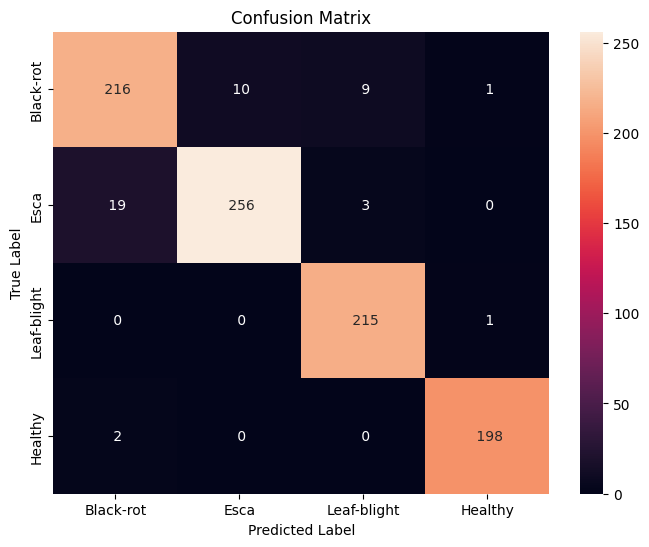

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(label_cpu, predictions_cpu)

labels = ['Black-rot','Esca','Leaf-blight','Healthy']
# cm_str = np.asarray(cf_matrix, dtype=str)
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot = True, fmt = ' ',xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.savefig('/content/confusion_matrix_swin.pdf', bbox_inches='tight')
plt.savefig('/content/confusion_matrix_swin.png', bbox_inches='tight')

plt.show()